# Histogram of Oriented Gradients

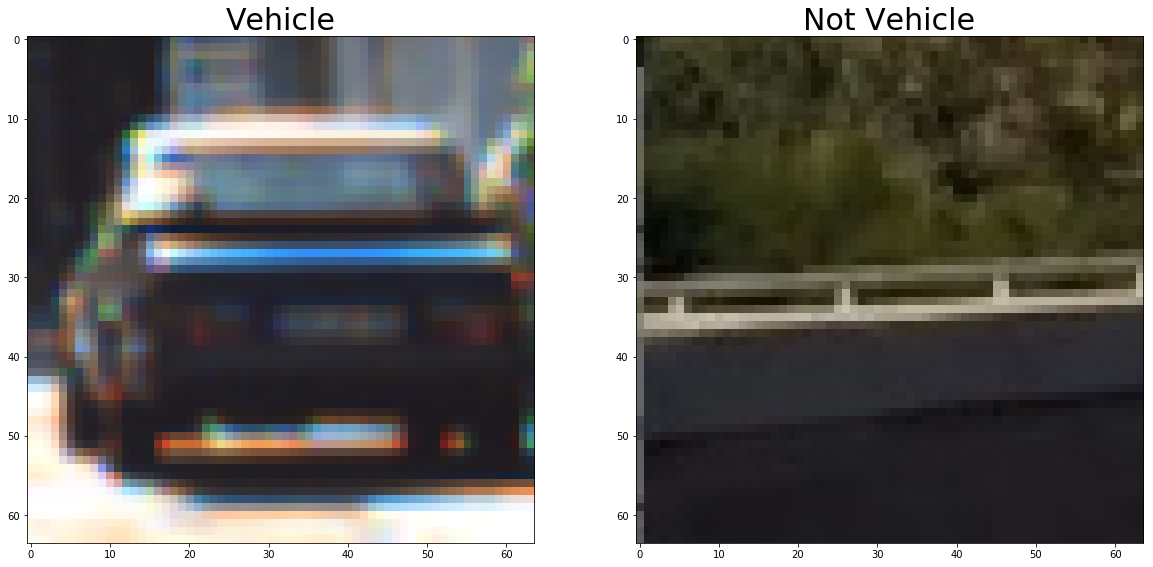

In [64]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

# Loading example images
vehicle = mpimg.imread('./vehicles/KITTI_extracted/1.png')
non_vehicle = mpimg.imread('./non-vehicles/Extras/extra12.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicle)
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(non_vehicle)
ax2.set_title('Not Vehicle', fontsize=30)

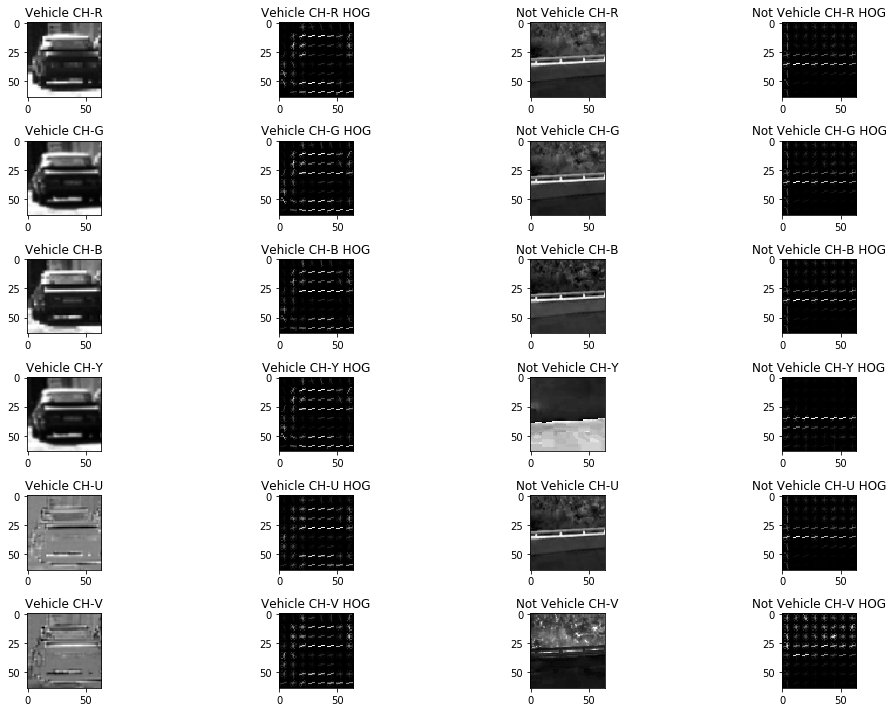

In [65]:
# compute hog features
from skimage.feature import hog
import cv2

%matplotlib inline

def get_hog_features(channel, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return np.array(features), hog_image
    else:      
        features = hog(channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return np.array(features)

yuv = cv2.cvtColor(vehicle, cv2.COLOR_RGB2YUV)
vehicle_channels = [('R', vehicle[:,:,0]),
                    ('G', vehicle[:,:,1]),
                    ('B', vehicle[:,:,2]),
                    ('Y', yuv[:,:,0]),
                    ('U', yuv[:,:,1]),
                    ('V', yuv[:,:,2])]

yuv = cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2HLS)
non_vehicle_channels = [('R', non_vehicle[:,:,0]),
                        ('G', non_vehicle[:,:,1]),
                        ('B', non_vehicle[:,:,2]),
                        ('Y', yuv[:,:,0]),
                        ('U', yuv[:,:,1]),
                        ('V', yuv[:,:,2])]

f, axarr = plt.subplots(6, 4, figsize=(15,10))

for i in range(6):

    _, hog_img = get_hog_features(vehicle_channels[i][1],
                                  orient=9,
                                  pix_per_cell=8,
                                  cell_per_block=2,
                                  vis=True)

    axarr[i][0].imshow(vehicle_channels[i][1], cmap='gray')
    axarr[i][0].set_title('Vehicle CH-{}'.format(vehicle_channels[i][0]))
    axarr[i][1].imshow(hog_img, cmap='gray')
    axarr[i][1].set_title('Vehicle CH-{} HOG'.format(vehicle_channels[i][0]))
        
for i in range(6):

    _, hog_img = get_hog_features(non_vehicle_channels[i][1],
                                  orient=9,
                                  pix_per_cell=8,
                                  cell_per_block=2,
                                  vis=True)

    axarr[i][2].imshow(non_vehicle_channels[i][1], cmap='gray')
    axarr[i][2].set_title('Not Vehicle CH-{}'.format(vehicle_channels[i][0]))
    axarr[i][3].imshow(hog_img, cmap='gray')
    axarr[i][3].set_title('Not Vehicle CH-{} HOG'.format(vehicle_channels[i][0]))

plt.tight_layout()

# Extracting Features

In [66]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

def extract_features(img):
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    hog1 = get_hog_features(YCrCb[:,:,0], orient, pix_per_cell, cell_per_block)
    hog2 = get_hog_features(YCrCb[:,:,1], orient, pix_per_cell, cell_per_block)
    hog3 = get_hog_features(YCrCb[:,:,2], orient, pix_per_cell, cell_per_block)

    spatial_features = bin_spatial(YCrCb)
    hist_features = color_hist(YCrCb)
    
    return np.concatenate((hog1, hog2, hog3))

# Support Vector Classifier

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

X, y = [], []

vehicles, non_vehicles = [], []
vehicles.extend(glob.glob('vehicles/KITTI_extracted/*.png'))
vehicles.extend(glob.glob('samples/positive/*.png'))
non_vehicles.extend(glob.glob('non-vehicles/Extras/*.png'))

for f in vehicles:
    im = mpimg.imread(f)
    if im.shape != (64, 64):
        im = cv2.resize(im, (64, 64))
    X.append(extract_features(im))
    y.append(1)
del vehicles 

for f in non_vehicles:
    im = mpimg.imread(f)
    if im.shape != (64, 64):
        im = cv2.resize(im, (64, 64))
    X.append(extract_features(im))
    y.append(0)    
del non_vehicles

X = np.array(X).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
X = X_scaler.transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# free up some memory
del X
del y

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [1 0 1 0 1 0 0 0 1 0]
For these 10 labels:  [1 0 1 0 1 0 0 0 1 0]
0.01476 Seconds to predict 10 labels with SVC


# Sliding Window Search

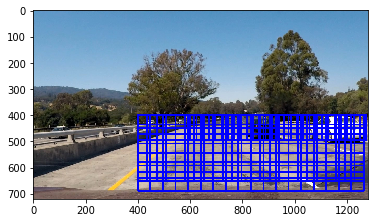

In [36]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def get_windows(image):
    windows = []
    windows.extend(slide_window(image, x_start_stop=[600, None], y_start_stop=[400, 500], xy_window=(96, 96)))
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[400, 680], xy_window=(144, 144)))
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[400, 700], xy_window=(192, 192)))
    return windows

image = mpimg.imread('test_images/test1.jpg')

imcopy = np.copy(image)
for w in get_windows(image):
    cv2.rectangle(imcopy, w[0], w[1], (0, 0, 255), 6)
    
plt.imshow(imcopy)

# Heatmap

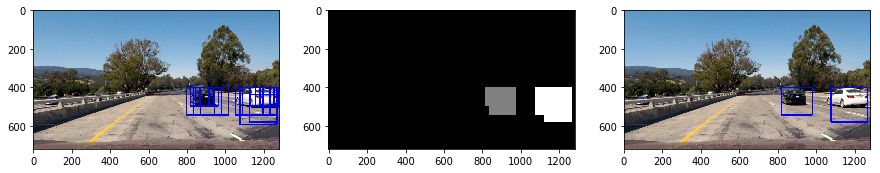

In [59]:
%matplotlib inline
from scipy.ndimage.measurements import label

decision_threshold = -2.0

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labels(img, bboxes, threshold = 1, filter_labels = None):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)

    if filter_labels is not None:
        heat[filter_labels[0] == 0] = 0
    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    return labels

def get_raw_bboxes(image):
    bboxes = []
    for w in get_windows(image):
        roi = cv2.resize(image[w[0][1]:w[1][1], w[0][0]:w[1][0]], (64, 64))
        features = extract_features(roi)
        scores = svc.decision_function(X_scaler.transform(np.array([features]).astype(np.float64)))
        if scores[0] > decision_threshold:
            bboxes.append(w)
            
    return bboxes

def get_final_bboxes(labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

imcopy = np.copy(image)
imcopy1 = np.copy(image)
raw_bboxes = get_raw_bboxes(image)
for bbox in raw_bboxes:
    cv2.rectangle(imcopy, bbox[0], bbox[1], (0, 0, 255), 6)

labels = get_labels(image, raw_bboxes)

for bbox in get_final_bboxes(labels):
    cv2.rectangle(imcopy1, bbox[0], bbox[1], (0, 0, 255), 6)
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
ax1.imshow(imcopy)
ax2.imshow(labels[0], cmap='gray')
ax3.imshow(imcopy1)

# Pipeline

In [60]:
class Processor(object):
    
    def __init__(self):
        self.raw_bboxes_list = []
        self.max_frames = 6

    def process(self, img):
        raw_bboxes = get_raw_bboxes(img)
        last_frame_labels = get_labels(img, raw_bboxes)

        if len(self.raw_bboxes_list) == self.max_frames:
            del self.raw_bboxes_list[0]
        self.raw_bboxes_list.append(raw_bboxes)
        
        bboxes_to_label = []
        for l in self.raw_bboxes_list:
            bboxes_to_label.extend(l)
        
        labels = get_labels(img, bboxes_to_label, threshold=16, filter_labels=last_frame_labels)        
        final_bboxes = get_final_bboxes(labels)
        
        imcopy = np.copy(img)
        for bbox in final_bboxes:
            cv2.rectangle(imcopy, bbox[0], bbox[1], (0, 0, 255), 2)

        return imcopy

# Video

In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_annotated.mp4'

processor = Processor()
video = VideoFileClip('project_video.mp4')
annotated_video = video.fl_image(processor.process)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|█████████▉| 1260/1261 [12:26<00:00,  1.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 12min 16s, sys: 1.66 s, total: 12min 18s
Wall time: 12min 27s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output_video = 'test_video_annotated.mp4'

processor = Processor()
video = VideoFileClip('test_video.mp4')
annotated_video = video.fl_image(processor.process)
%time annotated_video.write_videofile(test_output_video, audio=False)

[MoviePy] >>>> Building video test_video_annotated.mp4
[MoviePy] Writing video test_video_annotated.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_annotated.mp4 

CPU times: user 20.6 s, sys: 90 ms, total: 20.7 s
Wall time: 21.8 s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_video))